# 002_Post_Get_Organized
## Project by Tomasz Gusciora
## Visit my website: https://tgusciora.github.io/
## or my Substack: https://demistyfai.substack.com/
## or my github: https://github.com/TGusciora

In this project I will share some concepts of analytical projects organization for:
* ease of management
* possible automations
* use of standardized folder structure
* future reproducibility


### I. Packages import, notebook options, environment variables

In [1]:
# import packages - \src\utils\start_wrapper.py
from src.utils.start_wrapper import *

# enable autoreload - that way you don't have to reload modules, when you change them
wrapper_notebook_settings()

# Load dictionary of project paths
# crawler from parent directory
import src.utils.paths
paths = src.utils.paths.paths_dictionary()
print("Contents of paths dictionary:")
for key in paths:
    print(key, ": ", paths[key])


# Project specific modules (reusable!)
import src.data.make_dataset
import src.utils.df_inspect
import src.visualization.visualize

# Load environment variables - safe way to load sensitive data
import dotenv
import os
dotenv.load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env'))

# Why I dont have packages in utils.start_wrapper? Because pylint wouldn't recognize them
#  basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# project specific packages
import urllib.request
import sklearn as sk
from sklearn import metrics

# FB (Hi Mark) module for forecasting
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

Contents of paths dictionary:
data :  /app/data/
docs :  /app/docs/
models :  /app/models/
notebooks :  /app/notebooks/
references :  /app/references/
reports :  /app/reports/
src :  /app/src/
app :  /app/
data_external :  /app/data/external/
data_interim :  /app/data/interim/
data_processed :  /app/data/processed/
data_raw :  /app/data/raw/
reports_figures :  /app/reports/figures/
src_data :  /app/src/data/
src_features :  /app/src/features/
src_models :  /app/src/models/
src_utils :  /app/src/utils/
src_visualization :  /app/src/visualization/


### II. Parameters section
This is where all your modifyable parameters for the notebook should be

In [2]:
seed = 123  # random seed for reproducibility of results
forecast_days = 7  # number of days to forecast
start_date = '1984-09-07'
end_date = '2024-02-27'
stock = 'aapl.us'
model_name = 'm001_tg_appl'

np.random.seed(seed)  # setting random number generator in numpy for reproducibility of results

In [3]:
# Kids, don't do this at home
# example of calling environment variable
os.environ['secret_apiKey']

'S0_S3cR3T'

### III. Obtain, save and inspect raw Data

Do not meddle with raw data. This is why kittens end up in hell.

Raw data is there untouched so:
1) You can always reference back to it for checking your data processing quality
2) You can reproduce same analysis in the future and obtain same results (except for some experiments where random seed or stochastic processes are not controlllable, but still)
3) Just don't do it. https://www.youtube.com/watch?v=otCpCn0l4Wo

In [4]:
# Load data from Stooq using user-written function
data_in = src.data.make_dataset.stooqData(stock)

# Save data to csv
data_in.to_csv(paths['data_raw']+stock+'.csv', index=False) 

In [5]:
src.utils.df_inspect.DataFrameInspector(data_in)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9949 entries, 0 to 9948
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9949 non-null   datetime64[ns]
 1   open    9949 non-null   float64       
 2   high    9949 non-null   float64       
 3   low     9949 non-null   float64       
 4   close   9949 non-null   float64       
 5   volume  9949 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 466.5 KB
None 

First 5 Rows of the DataFrame:
        date      open      high       low     close        volume
0 1984-09-07  0.100763  0.101999  0.099546  0.100763  9.767604e+07
1 1984-09-10  0.100763  0.101071  0.098340  0.100165  7.581254e+07
2 1984-09-11  0.101071  0.103814  0.101071  0.101999  1.787705e+08
3 1984-09-12  0.101999  0.102597  0.098928  0.098928  1.561713e+08
4 1984-09-13  0.104432  0.104730  0.104432  0.104432  2.432310e+08 

Last 5 Rows of the Data

In [6]:
# Checking wheter close price is adjusted for stock splits or not
# Apple had 7:1 stock split in 2014-06-09
data_in[(data_in["date"].dt.year == 2014) & (data_in["date"].dt.month == 6)]

# Close price is adjusted

,date,open,high,low,close,volume
7495,2014-06-02,20.1924,20.2184,19.8275,20.0229,4.139481e+08
7496,2014-06-03,20.0169,20.3430,20.0120,20.3050,3.283111e+08
7497,2014-06-04,20.3021,20.6381,20.2592,20.5383,3.760571e+08
7498,2014-06-05,20.5833,20.6849,20.4675,20.6201,3.404549e+08
7499,2014-06-06,20.7009,20.7427,20.5273,20.5623,3.926505e+08
7500,2014-06-09,20.6699,20.9292,20.4566,20.8892,3.377682e+08
7501,2014-06-10,21.1216,21.1933,20.8614,21.0119,2.813494e+08
7502,2014-06-11,20.9860,21.1276,20.8394,20.9252,2.046828e+08
7503,2014-06-12,20.9630,20.9840,20.4895,20.5783,2.453256e+08
7504,2014-06-13,20.5583,20.6111,20.2612,20.3499,2.444800e+08


### IV. Data manipulation

As we each time download data from Stooq and we receive new observations, we want to limit them to set dates for analysis.  
For production purposes this wouldn't be the case as we would probably let our model to absorb new data everyday and correct its predictions based on ground truth (actual data).

In [ ]:
# Limit analysis to set-up dates in parameters
data_in = data_in[data_in["date"] >= start_date & (data_in["date"] <= end_date)]

### V. Train and test split

Train - sample on which our forecasting model will train itself  
Test - sample on which we will test quality of our models prediction  
  
Prophet (Hi Mark) requires us to set date variable as 'ds' and variable that we want to predict as 'y'.  
Otherwise it won't work.

In [7]:
# Train and test split - forecast_days last observations are used as test set

train = data_in[['date', 'close']][:-forecast_days].copy()  
train.columns = ['ds', 'y']
display('train dataset size:', train.shape)

test = data_in[['date', 'close']][-forecast_days:].copy()
test.columns = ['ds', 'y']  
display('train dataset size:', test.shape)

'train dataset size:'

(9942, 2)

'train dataset size:'

(7, 2)

In [26]:
# last observations of training dataset
train.tail()

,ds,y
9937,2024-02-13,185.04
9938,2024-02-14,184.15
9939,2024-02-15,183.86
9940,2024-02-16,182.31
9941,2024-02-20,181.56


In [27]:
# our test dataset contents
test

,ds,y
9942,2024-02-21,182.32
9943,2024-02-22,184.37
9944,2024-02-23,182.52
9945,2024-02-26,181.16
9946,2024-02-27,182.63
9947,2024-02-28,181.42
9948,2024-02-29,180.75


### VI. Train model

In [28]:
m = Prophet()
m.fit(train)

07:33:07 - cmdstanpy - INFO - Chain [1] start processing
07:33:13 - cmdstanpy - INFO - Chain [1] done processing


### VII. Use model to forecast the future

In [11]:
future = m.make_future_dataframe(periods=2*forecast_days)
future = future[future['ds'].dt.dayofweek < 5] # exclude weekends
future.tail(10)

,ds
9942,2024-02-21
9943,2024-02-22
9944,2024-02-23
9947,2024-02-26
9948,2024-02-27
9949,2024-02-28
9950,2024-02-29
9951,2024-03-01
9954,2024-03-04
9955,2024-03-05


In [12]:
# Predict the future
forecast = m.predict(future)

# yhat - forecasted value
# yhat_lower - lower bound of forecast (uncertainty interval)
# yhat_upper - upper bound of forecast (uncertainty interval)
# https://facebook.github.io/prophet/docs/uncertainty_intervals.html
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9947,2024-02-28,184.727371,175.296039,194.807630
9948,2024-02-29,184.702075,174.823064,194.324389
9949,2024-03-01,184.638441,174.518492,194.279794
9950,2024-03-04,184.779338,175.196429,194.923320
9951,2024-03-05,184.837862,174.236508,194.817533


### VII. Evaluate models prediction

In [14]:
# Compare ground truth y with forecast yhat
test_forecast = test.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
test_forecast.tail()

,ds,y,yhat,yhat_lower,yhat_upper
2,2024-02-23,182.52,184.585043,174.054111,194.948884
3,2024-02-26,181.16,184.657451,174.139474,195.538237
4,2024-02-27,182.63,184.686778,174.133211,194.767959
5,2024-02-28,181.42,184.727371,175.296039,194.807630
6,2024-02-29,180.75,184.702075,174.823064,194.324389


In [15]:
full_sample = pd.concat([train, test_forecast], ignore_index=True, sort=False)
full_sample = full_sample[full_sample['y'].notnull()] # remove rows without ground truth

In [16]:
full_sample.tail(2*forecast_days)

,ds,y,yhat,yhat_lower,yhat_upper
9935,2024-02-09,188.85,NaN,NaN,NaN
9936,2024-02-12,187.15,NaN,NaN,NaN
9937,2024-02-13,185.04,NaN,NaN,NaN
9938,2024-02-14,184.15,NaN,NaN,NaN
9939,2024-02-15,183.86,NaN,NaN,NaN
9940,2024-02-16,182.31,NaN,NaN,NaN
9941,2024-02-20,181.56,NaN,NaN,NaN
9942,2024-02-21,182.32,184.700019,173.881461,194.645714
9943,2024-02-22,184.37,184.663865,174.726378,195.093603
9944,2024-02-23,182.52,184.585043,174.054111,194.948884


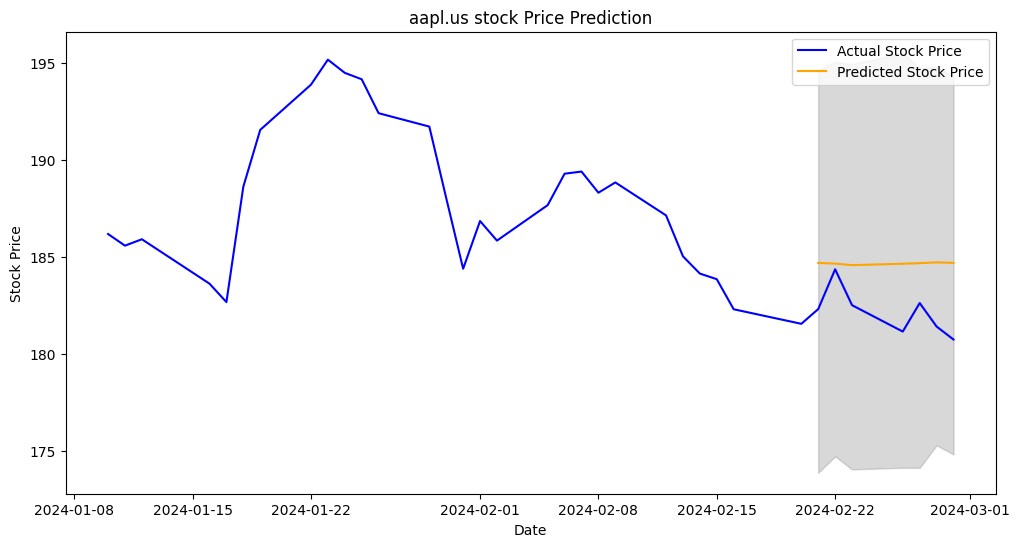

In [17]:
# Plotting
src.visualization.visualize.prophet_plot_forecast(data = full_sample, title = stock, obs = forecast_days)


In [18]:
# Export full dataset
full_sample.to_csv(paths['data_processed']+'forecast_full_sample.csv', index=False) 

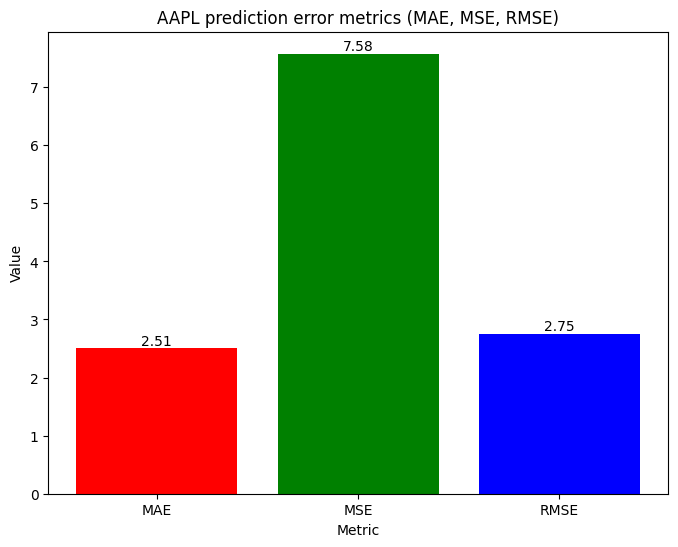

In [19]:
# Prediction errors
src.visualization.visualize.plot_forecast_error(data = full_sample, title = 'AAPL', path = paths['reports_figures'])

# image of a poor prophet
# bad prophet, bad

### IX. Exporting your model for future use

For Prophet (Hi Mark) there can be problems with pickling -> hence we use serialization
https://facebook.github.io/prophet/docs/serialization.html

In [20]:
# Python serializing


with open(paths['models'] + model_name + '.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [21]:
with open(paths['models'] + model_name + '.json', 'r') as fin:
    m_test = model_from_json(fin.read())  # Load model

### X. Check if your re-loaded model predicts same values as the old one

In [22]:
np.random.seed(seed) # we have to set random seed again - checked empirically
forecast_check = m_test.predict(future)

# Assuming df1 and df2 are your DataFrames
import pandas.testing
try:
    pandas.testing.assert_frame_equal(forecast, forecast_check)
    are_completely_same = True
except AssertionError:
    are_completely_same = False
print(f"Are the two DataFrames the same? {are_completely_same}")

# confidence intervals yhat_lower and yhat_uppe would be different if we wouldnt set np.random.seed(seed) to constant value

Are the two DataFrames the same? True


https://github.com/facebook/prophet/issues/1124

Stochasticity comes in the prediction stage, and derives entirely from the trend uncertainty estimation. Increasing uncertainty_samples reduces variance in yhat_upper but it is still stochastic.